In [1]:
# import os
import pandas as pd
import numpy as np
import spacy
# import json
# from sklearn.model_selection import train_test_split


In [2]:
train_data_raw = 'phase1_lymphoma.json'
test_data_raw = 'phase1_lungcancer.json'

# columns of interest
[
    'study_duration_days',
    'study_eq_bins',
    'study_eq_labels',
    'num_oms',
    'masking',
    'number_of_intervention_types',
    "num_locations",
    'number_of_conditions',
    'allocation',
    'masking',
    'enroll_count',
    'biological_intervention',
    'procedure_intervention',
    'drug_intervention',
    'radiation_intervention',
    'treatment_purpose',
    'prevention_purpose',
    'us_led',
    'us_included',
    'nci_sponsor'
]

In [3]:
def validate_columns(file, yaml_file):
    
    if '.csv' in file:
        df = pd.read_csv(file)
    elif '.json' in file:
       raw_df = pd.read_json(file)
       df = pd.json_normalize(raw_df['protocolSection'], sep='_')
       df.columns = ['protocolSection_' + col for col in df.columns]

    # Load YAML schema
    config = load_yaml(yaml_file)

    # Validate columns
    expected_columns = config['columns']
    actual_columns = df.columns.tolist()

    missing_columns = [col for col in expected_columns if col not in actual_columns]
    # extra_columns = [col for col in actual_columns if col not in expected_columns]

    if missing_columns:
        missing_msg = f"Missing columns in CSV: {', '.join(missing_columns)}"
        logger.warning(missing_msg)
        print(missing_msg)

    # if not missing_columns and not extra_columns:
    if not missing_columns:
        success_msg = "CSV file columns match the YAML schema."
        logger.info(success_msg)
        print(success_msg)
    return df

# Function to convert dates to datetime, handling YYYY-MM format
def convert_to_datetime(date_str):
    try:
        return pd.to_datetime(date_str, format='%Y-%m-%d')
    except ValueError:
        try:
            return pd.to_datetime(date_str, format='%Y-%m') + pd.offsets.MonthBegin(0)  # Assume first day of the month
        except ValueError:
            return np.nan  # If conversion fails, return NaN

def safe_eval(item):
    if isinstance(item, str):  # Check if the item is a string
        return eval(item)
    return item  # Return the item unchanged if it's not a string

# Function to extract 'type' from list of dictionaries
def extract_type(interventions):
    return [d['type'] for d in interventions]

# function to count number of sites
def count_loc(value):
  if pd.isna(value):
    return np.nan
  else:
    new_string = value.split(", ")
    counter = 0
    for i in new_string:
      if "facility" in i:
        counter += 1
    return counter

# function to count number of sites
def trial_loc(value):
  if pd.isna(value):
    return np.nan
  else:
    new_string = value.split(", ")
    temp_list = []
    for i in new_string:
      if "country" in i:
        temp_list.append(i)
    has_us = [i for i in temp_list if "United States" in i]

    if all(i == temp_list[0] for i in temp_list) and has_us:
        loc = 'USA'
    elif not has_us:
        loc = "non-USA"
    else:
        loc = "USA & non-USA"
    return loc

def extract_measures(outcomes):
    # Check if 'outcomes' is iterable (i.e., a list in this context)
    if isinstance(outcomes, list):
        return [item.get('measure', 'No description available') for item in outcomes]
    else:
        return ['No description available']  # Return a list with a default message if not iterable

# Extracting timeframe in number of days    
def extract_timeframes(outcomes):
    # Check if 'outcomes' is iterable (i.e., a list in this context)
    if isinstance(outcomes, list):
        return [item.get('timeFrame', 'No description available') for item in outcomes]
    else:
        return ['No description available']  # Return a list with a default message if not iterable


def extract_time_length_from_list(timeFrames):
    # Dictionary to convert written numbers to numeric values
    written_numbers = {
        "one": 1, "two": 2, "three": 3, "four": 4, "five": 5, 
        "six": 6, "seven": 7, "eight": 8, "nine": 9, "ten": 10,
        "eleven": 11, "twelve": 12, "thirteen": 13, "fourteen": 14,
        "fifteen": 15, "sixteen": 16, "seventeen": 17, "eighteen": 18,
        "nineteen": 19, "twenty": 20
    }

    # Regular expression components
    number_pattern = r"(\d+(\.\d+)?)"
    written_number_pattern = r"(one|two|three|four|five|six|seven|eight|nine|ten|eleven|twelve|thirteen|fourteen|fifteen|sixteen|seventeen|eighteen|nineteen|twenty)"
    unit_pattern = r"(hour|day|week|month|year|minute)s?"
    reversed_pattern = rf"(?P<unit3>{unit_pattern})\s+(?P<number2>\d+(\.\d+)?)"

    # Combine the components into a single regular expression with VERBOSE flag for readability
    time_pattern = re.compile(
        rf"""
        (?:
            (?P<number>{number_pattern})\s*(?P<unit1>{unit_pattern})           # Numeric values followed by unit
            |                         # OR
            (?P<written>{written_number_pattern})\s*(?P<unit2>{unit_pattern})   # Written out numbers followed by unit
            |                         # OR
            {reversed_pattern}         # Reversed order: Day 15
        )
        """,
        re.IGNORECASE | re.VERBOSE
    )

    # Function to extract time length from a single timeframe string
    def extract_time_length(timeFrame):
        results = time_pattern.findall(timeFrame)
        time_durations = []
        
        for result in results:
            if result[0]:  # Numeric values followed by unit
                number = result[0]
                unit = result[3]
            elif result[5]:  # Written out numbers followed by unit
                number = written_numbers[result[5].lower()]
                unit = result[7]
            elif result[10]:  # Reversed order: Day 15
                number = result[11]
                unit = result[9]

            if isinstance(number, str):
                number = float(number)
            time_durations.append((number, unit.lower()))
        return time_durations
    
    combined_durations = []
    for timeFrame in timeFrames:
        if timeFrame:  # This checks if the timeFrame is not empty or None
            combined_durations.extend(extract_time_length(timeFrame))
    return combined_durations

def convert_to_days(amount, unit):
    if unit == 'minutes' or unit == 'minute':
        return np.ceil(amount / 1440)
    elif unit == 'hours' or unit =='hour' :
        return np.ceil(amount / 24)
    elif unit == 'weeks' or unit == 'week':
        return amount * 7
    elif unit == 'months' or unit == 'month':
        return amount * 30  # Simplified conversion, assuming each month has 30 days
    elif unit == 'years' or unit == 'year':
        return amount * 365  # Simplified conversion, assuming each year has 365 days
    elif unit == 'days' or unit =='day':
        return amount
    else:
        return 0

def find_max_duration(durations):
    if not durations:  # Check if the list is empty
        return np.nan  # Use numpy Nan to indicate no data
    max_days = max(convert_to_days(amount, unit) for amount, unit in durations)
    return max_days

# Function to remove specified characters
def remove_special_chars(col):
    return col.replace("[", "").replace("]", "").replace("'", "").replace(", ", "_")

def count_criteria(criteria):
    if pd.isna(criteria):
        return np.nan, np.nan
    # pattern
    # line break, \n, followed by any amount of whitespace
    # followed by an alphanumeric character 1-2 characters in length followed by a period
    # OR an asterisk
    # OR a hyphen
    pattern =  r'\n\s*\w{1,2}\.|[*]|\-'
    if "exclusion criteria" in criteria.lower():
        parts = criteria.lower().split("exclusion criteria")
        inclusion_criteria = parts[0]
        exclusion_criteria = parts[1]

        inclusion_matches = re.findall(pattern, inclusion_criteria)
        exclusion_matches = re.findall(pattern, exclusion_criteria)
        num_inclusion = len(inclusion_matches)
        num_exclusion = len(exclusion_matches)
    else:
        inclusion_matches = re.findall(pattern, criteria)
        num_inclusion = len(inclusion_matches)
        num_exclusion = np.nan
    
    return num_inclusion, num_exclusion

def conditions_map(condition):
  if 'cell lung' in condition:
    return 'squamous cell'
  if 'head and neck' in condition:
    return 'squamous cell'
  if 'squamous cell' in condition:
    return 'squamous cell'
  if 'small cell' in condition:
    return 'squamous cell'
  if 'lung' in condition:
    return 'squamous cell'
  if 'keratosis' in condition:
    return 'squamous cell'
  if 'myeloma' in condition:
    return 'myeloma'
  if 'sarcoma' in condition:
    return 'sarcoma'
  if 'lymphoma' in condition:
    return 'lymphoma'
  if 'brain cancer' in condition:
    return 'brain'
  if 'melanoma' in condition:
    return 'melanoma'
  if 'adenocarcinoma' in condition:
    return 'adeno'
  if 'prostate cancer' in condition:
    return 'adeno'
  if 'breast' in condition:
    return 'ductal'
  if 'leukemia' in condition:
    return 'leukemia'
  if 'colorectal' in condition:
    return 'adeno'
  if 'glioblastoma' in condition:
    return 'brain'
  if 'kidney' in condition:
    return 'adeno'
  if 'renal' in condition:
    return 'adeno'
  if 'hematopoietic' in condition:
    return 'leukemia'
  if 'lymphoid' in condition:
    return 'lymphoma'
  if 'cervix' in condition:
    return 'adeno'
  if 'cervical' in condition:
    return 'adeno'
  if 'liver' in condition:
    return 'adeno'
  if 'hepatic' in condition:
    return 'adeno'
  if 'hepatocellular' in condition:
    return 'adeno'
  if 'nsclc' in condition:
    return 'squamous cell'
  if 'thyroid' in condition:
    return 'adeno'
  if 'pain' in condition:
    return 'pain'
  elif 'carcinoma' in condition:
    return 'carcinoma'
  return 'other'

def list_to_lower_string(lst):
    # Ensure the input is a list
    if isinstance(lst, list):
        # Convert each element to a lowercase string and join with spaces
        return ", ".join(map(str, lst)).lower()

def drop_outliers(df, threshold=5):
    # Calculate the mean and standard deviation for each column
    means = df.mean()
    stds = df.std()
    # Identify outliers
    outliers = (np.abs((df - means) / stds) > threshold)
    # Create a DataFrame to store the outliers
    dropped_values = df[outliers]
    # Drop the rows with outliers
    df_cleaned = df.drop(index=dropped_values.dropna(how='all').index)
    return df_cleaned

def interval_to_string(o):
    if isinstance(o, pd.Interval):
        return str(o)
    raise TypeError(f"Object of type {o.__class__.__name__} is not JSON serializable")

def save_dict_to_json(filename, data):
    with open(filename, 'w') as json_file:
        json.dump(data, json_file, indent=4, default=interval_to_string)

def convert_dtypes(df):
    # Convert all int64 columns to int
    int_cols = df.select_dtypes(include=['int8', 'int16', 'int32', 'int64']).columns
    df[int_cols] = df[int_cols].astype(int)
    
    # Convert all float64 columns to float
    float_cols = df.select_dtypes(include=['float16', 'float32', 'float64']).columns
    df[float_cols] = df[float_cols].astype(float)
    
    return df

def trial_loc_counter(value):
    # Initialize the counter
    counter = {"USA": 0, "non-USA": 0}
    
    # Check if the value is a list of dictionaries
    if isinstance(value, list):
        for i in value:
            if isinstance(i, dict) and 'country' in i:
                if i['country'] == 'United States':
                    counter["USA"] += 1
                else:
                    counter["non-USA"] += 1
        # Return True if USA has more counts than non-USA
        return counter['USA'] > counter['non-USA']
    else:
        # Return a default or handle the error case as appropriate
        return False
    
def check_crossover(item):
    if isinstance(item, str):  # Ensure item is a string
        # Check if "CROSSOVER" is in the string
        return "CROSSOVER" in item.upper()  # Convert to uppercase for case-insensitive check
    return False  # Return False if item is not a string

def create_all_terms(value):
    if isinstance(value, (list, dict)):
        all_terms = []
        for i in value:
            text = i["measure"].lower()
            all_terms.append(text)
        return all_terms
    else:
        return np.nan

def concatenate_strings(series:list):
    # Filter out np.nan and flatten the lists
    all_strings = []
    for i in series:
        all_strings.extend(i.dropna().sum())  # Concatenate lists while dropping NaN
    return ' '.join(all_strings)

def spacy_list(keyword:str, ref_text):
    # Process the keyword and the large text
    keyword_doc = nlp(keyword)
    text_doc = nlp(ref_text)

    # Set a threshold for similarity
    similarity_threshold = 0.8

    high_similarity_phrases = []
    seen_phrases = set()  # Set to track unique words or phrases

    # Check individual tokens
    for token in text_doc:
        # Skip stop words and punctuation
        if not token.is_stop and not token.is_punct:
            # Compute similarity
            similarity_score = token.similarity(keyword_doc)
            if similarity_score >= similarity_threshold and token.text not in seen_phrases:
                high_similarity_phrases.append((token.text, similarity_score))
                seen_phrases.add(token.text)  # Add to the set of seen phrases

    # Check multi-word phrases
    for chunk in text_doc.noun_chunks:
        # Compute similarity with the keyword
        similarity_score = chunk.similarity(keyword_doc)
        if similarity_score >= similarity_threshold and chunk.text not in seen_phrases:
            high_similarity_phrases.append((chunk.text, similarity_score))
            seen_phrases.add(chunk.text)  # Add to the set of seen phrases
    return high_similarity_phrases

def check_terms_in_outcomes(outcomes, terms):
    if isinstance(outcomes, list):  # Only proceed if 'outcomes' is a list
        for outcome in outcomes:
            if isinstance(outcome, dict):  # Ensure each item is a dictionary
                for value in outcome.values():  # Check each value in the dictionary
                    if isinstance(value, str) and any(term in value for term, _ in terms):
                        return True
    return False

def check_tmax_in_outcomes(outcomes, terms):
    if isinstance(outcomes, list):  # Only proceed if 'outcomes' is a list
        for outcome in outcomes:
            if isinstance(outcome, dict):  # Ensure each item is a dictionary
                for value in outcome.keys():  # Check each value in the dictionary
                    if value == terms:
                        return True
    return False

In [4]:
raw_df = pd.read_json(train_data_raw)
df = pd.json_normalize(raw_df['protocolSection'], sep='_')
df.columns = ['protocolSection_' + col for col in df.columns]
df

,protocolSection_identificationModule_nctId,protocolSection_identificationModule_orgStudyIdInfo_id,protocolSection_identificationModule_organization_fullName,protocolSection_identificationModule_organization_class,protocolSection_identificationModule_briefTitle,protocolSection_identificationModule_officialTitle,protocolSection_statusModule_statusVerifiedDate,protocolSection_statusModule_overallStatus,protocolSection_statusModule_expandedAccessInfo_hasExpandedAccess,protocolSection_statusModule_startDateStruct_date,...,protocolSection_statusModule_dispFirstPostDateStruct_date,protocolSection_statusModule_dispFirstPostDateStruct_type,protocolSection_outcomesModule_otherOutcomes,protocolSection_designModule_designInfo_maskingInfo_whoMasked,protocolSection_oversightModule_isUsExport,protocolSection_designModule_designInfo_maskingInfo_maskingDescription,protocolSection_referencesModule_availIpds,protocolSection_statusModule_expandedAccessInfo_nctId,protocolSection_statusModule_expandedAccessInfo_statusForNctId,protocolSection_oversightModule_isUnapprovedDevice
0,NCT03316144,Junshi-JS001-011,"Shanghai Junshi Bioscience Co., Ltd.",OTHER,"Safety, Tolerability, Pharmacokinetics & Pharm...","A Phase I Study of Safety, Tolerability, Pharm...",2020-09,COMPLETED,False,2017-07-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NCT01212341,MG4101_P1,Seoul National University Hospital,OTHER,Allogeneic Natural Killer (NK) Cell Therapy in...,A Phase I Study of Allogeneic NK Cell Therapy ...,2013-08,COMPLETED,False,2010-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NCT01800630,HR-12-001,InnoPharmax Inc.,INDUSTRY,Phase1 Study of Gemcitabine HCl Oral Formulati...,"An Open Label, Phase 1, Dose Escalation Study ...",2019-07,COMPLETED,False,2013-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NCT01065025,4SC-205-1-2009,4SC AG,INDUSTRY,"Open Label, Dose Escalation Trial of Oral Eg5 ...","Open Label, Dose Escalation Trial of Oral 4SC-...",2015-04,COMPLETED,False,2010-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NCT01588548,D4510C00005,AstraZeneca,INDUSTRY,Global Phase1 Study to Assess the Safety and T...,"A Phase I, Open-Label, Multicentre Study to As...",2015-10,COMPLETED,False,2012-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,NCT00004910,NU 98CC2,Northwestern University,OTHER,Endoscopic Placement of Metal Stents in Treati...,A Pilot Phase I/II Trial of Enteral Wallstents...,2012-05,COMPLETED,False,2000-01,...,2011-02-25,ESTIMATED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1096,NCT00654160,CDR0000592931,Mayo Clinic,OTHER,"Irinotecan, Fluorouracil, and Leucovorin in Tr...",A Pharmacogenetic-Based Phase I Trial of Irino...,2016-09,COMPLETED,False,2008-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1097,NCT00003867,CDR0000067031,Montefiore Medical Center,OTHER,Irinotecan and Capecitabine in Treating Patien...,Phase I Clinical Study of Every Three Week Iri...,2018-09,COMPLETED,False,1999-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1098,NCT00397384,NCI-2009-00107,National Cancer Institute (NCI),NIH,Erlotinib Hydrochloride and Cetuximab in Treat...,A Phase I Clinical and Biological Evaluation o...,2014-02,COMPLETED,False,2007-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# len of rows
rows0 = len(df)

#study duration, float
df['start_date'] = df['protocolSection_statusModule_startDateStruct_date'].apply(convert_to_datetime)
df['primary_completion_date'] = df['protocolSection_statusModule_primaryCompletionDateStruct_date'].apply(convert_to_datetime)
df['completion_date'] = df['protocolSection_statusModule_completionDateStruct_date'].apply(convert_to_datetime)
df['primary_study_duration_days'] = (df['primary_completion_date'] - df['start_date']).dt.days
df['study_duration_days'] = (df['completion_date'] - df['start_date']).dt.days

# cols that are vital for accurate prediction
need_cols = [
    # 'primary_study_duration_days',
    'protocolSection_statusModule_startDateStruct_date',
    'protocolSection_statusModule_primaryCompletionDateStruct_date',
    'protocolSection_statusModule_completionDateStruct_date',]
    # 'study_duration_days',
    # 'protocolSection_designModule_enrollmentInfo_count']

# remove rows with NaNs for primary_study_duration_days, study_duration_days,
df = df.dropna(subset=need_cols).copy()
# len of rows after dropping NaNs
rows1 = len(df)
msg = f"{rows0 - rows1} rows were dropped due to missing values in one of: {need_cols}"
# logger.info(msg)
print(msg)

# make bins with average duration
avg_dur = np.mean(df['study_duration_days'])
df['study_eq_bins'] = pd.cut(df['study_duration_days'], bins=[df['study_duration_days'].min(), avg_dur, df['study_duration_days'].max()], labels=['Low', 'High'], right=False)

df['study_eq_labels'] = df['study_eq_bins'].cat.codes

bins_dict = df.groupby('study_eq_labels')['study_eq_bins'].apply(lambda x: x.unique()[0]).to_dict()
msg2 = f"Bin labels and their corresponding intervals are: {bins_dict}"
print(msg2)
# logger.info(msg2)

# sponsor type, categorical
spon_map = {
    'OTHER_GOV': 'OTHER',
    'NETWORK': 'OTHER',
    'NIH': 'OTHER',
    'FED': 'OTHER',
    'INDIV': 'OTHER'
}

spon_map2 = {
    "INDUSTRY": True,
    "OTHER": False
}

df['sponsor_type0'] = df['protocolSection_sponsorCollaboratorsModule_leadSponsor_class'].replace(spon_map)
df['sponsor_type'] = df['sponsor_type0'].map(spon_map2)

# responsible party, categorical (mapped to int)
party_map = {
    "PRINCIPAL_INVESTIGATOR": 0,
    "SPONSOR": 1,
    "SPONSOR_INVESTIGATOR": 2
}

df['resp_party'] = df['protocolSection_sponsorCollaboratorsModule_responsibleParty_type'].map(party_map)

# allocation, categorical (mapped to int)
allo_map = {
    'NON_RANDOMIZED': False,
    'RANDOMIZED': True
}

df['allocation'] = df['protocolSection_designModule_designInfo_allocation'].map(allo_map)

df['masking'] = df['protocolSection_designModule_designInfo_maskingInfo_masking'].apply(lambda x: False if x == "NONE" else True)

# number of conditions, int
df['protocolSection_conditionsModule_conditions'] = df['protocolSection_conditionsModule_conditions'].apply(safe_eval)
df['number_of_conditions'] = df['protocolSection_conditionsModule_conditions'].apply(lambda x: len(x))

# number of outcome measures, int
oms = [col for col in df.columns if "outcome" in col]
for i in oms:
    df[i].apply(list_to_lower_string)
    df[f"num_{i}"] = df[i].apply(lambda x: len(x) if isinstance(x, list) else 0)
num_om_cols = [col for col in df.columns if "num" in col and "outcome" in col]
df['num_oms'] = df[num_om_cols].sum(axis=1)

# primary purpose, bool/int
# Extract purposes into new columns
df['protocolSection_designModule_designInfo_primaryPurpose'] = df['protocolSection_designModule_designInfo_primaryPurpose'].fillna('')
df['treatment_purpose'] = df['protocolSection_designModule_designInfo_primaryPurpose'].apply(lambda x: 1 if 'TREATMENT' in x else 0)
df['prevention_purpose'] = df['protocolSection_designModule_designInfo_primaryPurpose'].apply(lambda x: 1 if 'PREVENTION' in x else 0)

# intervention type, bool/int
# Extract interventions into new columns
df['procedure_intervention'] = df['protocolSection_armsInterventionsModule_interventions'].apply(lambda x: True if 'PROCEDURE' in x else False)
df['drug_intervention'] = df['protocolSection_armsInterventionsModule_interventions'].apply(lambda x: True if 'DRUG' in x else False)
df['radiation_intervention'] = df['protocolSection_armsInterventionsModule_interventions'].apply(lambda x: True if 'RADIATION' in x else False)
df['biological_intervention'] = df['protocolSection_armsInterventionsModule_interventions'].apply(lambda x: True if 'BIOLOGICAL' in x else False)

# number of intervention types, int
df['protocolSection_armsInterventionsModule_interventions'] = df['protocolSection_armsInterventionsModule_interventions'].apply(safe_eval)
df['intervention_types'] = df['protocolSection_armsInterventionsModule_interventions'].apply(extract_type)
df['number_of_intervention_types'] = df['intervention_types'].apply(len)

# number of locations, int
df["num_locations"] = df["protocolSection_contactsLocationsModule_locations"].astype(str).apply(count_loc)

loc_map = {
    "USA": 0,
    "non-USA": 1,
    "USA & non-USA": 2
}
# location of trials, US-led, bool
# "Trial primarily led in the US"
# I'm interpreting this to mean there are more trial sites in the USA than outside the USA
df['us_led'] = df["protocolSection_contactsLocationsModule_locations"].apply(lambda x: trial_loc_counter(x))
# location of trials, US-included, bool
df['us_included'] = df["protocolSection_contactsLocationsModule_locations"].astype(str).apply(trial_loc).apply(lambda x: True if x == "USA" or x == "USA & non-USA" else False)

# nic sponsorship, bool
df['nci_sponsor'] = df['protocolSection_sponsorCollaboratorsModule_leadSponsor_name'].apply(lambda x: True if "National Cancer Institute (NCI)" in x else False)

# crossover assignment, bool
df['crossover'] = df['protocolSection_designModule_designInfo_interventionModel'].apply(check_crossover)

# outcome measures, bool/int
# Combine outcome measures
df['all_primary_terms'] = df['protocolSection_outcomesModule_primaryOutcomes'].apply(lambda x: create_all_terms(x))
df["all_secondary_terms"] = df['protocolSection_outcomesModule_secondaryOutcomes'].apply(lambda x: create_all_terms(x))
# create a string all text from outcome measures in it for spacy perusal
all_terms = concatenate_strings([df['all_primary_terms'],df["all_secondary_terms"]]) # text from both primary and secondary measures
primary_terms = concatenate_strings([df['all_primary_terms']]) # test from primary measures only
# load the spacy model
nlp = spacy.load("en_core_web_md")  # Load the medium-sized model

# initiate dictionaries to hold the list of terms with the highest similarity values as calculated by spacy
spacy_dict = {}
lead_spacy_dict = {}

# create a list of the terms of intererst (for overall outcome measures)
terms = {
    "aes": "adverse events",
    "osr": "overall survival rate",
    "mtd": "maximally tolerated dose",
    "dor": "duration of response",
    "dlt": "dose limiting toxicity",
    "cmax": "maximum measured concentration"
}
# for primary outcome measures only
lead_terms = {
    "aes": "adverse events",
    "mtd": "maximally tolerated dose",
    "dlt": "dose limiting toxicity",
}

# fill the dictionaries
for i in terms:
    spacy_dict[i] = spacy_list(keyword=terms[i], ref_text=all_terms)
for i in lead_terms:
    lead_spacy_dict[i] = spacy_list(keyword=terms[i], ref_text=primary_terms)

#create the boolean outcome measure features
df['outcome_measures'] = df['protocolSection_outcomesModule_primaryOutcomes'].apply(lambda x: x if isinstance(x, list) else [x]).fillna('') + \
                        df['protocolSection_outcomesModule_secondaryOutcomes'].apply(lambda x: x if isinstance(x, list) else [x]).fillna('')

for i in terms:
    df[f"spacy_{i}_outcome"] = df['outcome_measures'].apply(
    lambda x: check_terms_in_outcomes(x, spacy_dict[i])
)

for i in lead_terms:
    df[f"spacy_{i}_lead_outcome"] = df['protocolSection_outcomesModule_primaryOutcomes'].apply(
    lambda x: check_terms_in_outcomes(x, lead_spacy_dict[i])
)

# tmax measure, bool
    # if the cmax is included in outcome measure and the timeframe of the cmax is included
df['spacy_tmax_outcome'] = df.loc[df["spacy_cmax_outcome"] == True, 'outcome_measures'].apply(
    lambda x: check_tmax_in_outcomes(x, "timeFrame"))

# rename some columns
df = df.rename(columns={'protocolSection_designModule_enrollmentInfo_count': 'enroll_count'})

# df['phase'] = df['phase'].astype(str)

#make a dataframe with just the columns of interest
cols = [
    'study_duration_days',
    'study_eq_bins',
    'study_eq_labels',
    'num_oms',
    'masking',
    'number_of_intervention_types',
    "num_locations",
    'number_of_conditions',
    'allocation',
    'enroll_count',
    'biological_intervention',
    'procedure_intervention',
    'drug_intervention',
    'radiation_intervention',
    'treatment_purpose',
    'prevention_purpose',
    'us_led',
    'us_included',
    'nci_sponsor',
    'spacy_aes_outcome',
    'spacy_osr_outcome',
    'spacy_mtd_outcome',
    'spacy_dor_outcome',
    'spacy_dlt_outcome',
    'spacy_cmax_outcome',
    'spacy_aes_lead_outcome',
    'spacy_dlt_lead_outcome',
    'spacy_mtd_lead_outcome',
    'spacy_tmax_outcome'
]

clean_df = df[cols].copy()

49 rows were dropped due to missing values in one of: ['protocolSection_statusModule_startDateStruct_date', 'protocolSection_statusModule_primaryCompletionDateStruct_date', 'protocolSection_statusModule_completionDateStruct_date']
Bin labels and their corresponding intervals are: {-1: nan, 0: 'Low', 1: 'High'}


/var/folders/t7/9qpt6ghx7x132zp3932q2fb80000gn/T/ipykernel_72909/937492853.py:365: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similarity_score = token.similarity(keyword_doc)
/var/folders/t7/9qpt6ghx7x132zp3932q2fb80000gn/T/ipykernel_72909/937492853.py:373: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  similarity_score = chunk.similarity(keyword_doc)


In [6]:
clean_df.isna().sum()

study_duration_days               0
study_eq_bins                     1
study_eq_labels                   0
num_oms                           0
masking                           0
number_of_intervention_types      0
num_locations                     0
number_of_conditions              0
allocation                      613
enroll_count                     30
biological_intervention           0
procedure_intervention            0
drug_intervention                 0
radiation_intervention            0
treatment_purpose                 0
prevention_purpose                0
us_led                            0
us_included                       0
nci_sponsor                       0
spacy_aes_outcome                 0
spacy_osr_outcome                 0
spacy_mtd_outcome                 0
spacy_dor_outcome                 0
spacy_dlt_outcome                 0
spacy_cmax_outcome                0
spacy_aes_lead_outcome            0
spacy_dlt_lead_outcome            0
spacy_mtd_lead_outcome      

In [7]:
# Select only the categorical columns (object type)
categorical_columns = clean_df.select_dtypes(include=['object']).columns

# Replace NaN with "missing" in categorical columns
clean_df[categorical_columns] = clean_df[categorical_columns].fillna('missing')

clean_df

,study_duration_days,study_eq_bins,study_eq_labels,num_oms,masking,number_of_intervention_types,num_locations,number_of_conditions,allocation,enroll_count,...,spacy_aes_outcome,spacy_osr_outcome,spacy_mtd_outcome,spacy_dor_outcome,spacy_dlt_outcome,spacy_cmax_outcome,spacy_aes_lead_outcome,spacy_dlt_lead_outcome,spacy_mtd_lead_outcome,spacy_tmax_outcome
0,901.0,Low,0,3,False,1,1,1,False,13.0,...,True,False,False,False,False,False,True,False,False,missing
1,912.0,Low,0,4,False,1,1,2,False,18.0,...,False,True,False,False,True,False,False,True,False,missing
2,1065.0,Low,0,5,False,1,3,2,missing,37.0,...,False,False,False,False,False,True,False,False,False,True
3,1916.0,High,1,4,False,1,2,2,missing,60.0,...,False,True,True,False,True,True,False,True,True,True
4,730.0,Low,0,1,False,1,3,2,False,43.0,...,False,False,False,False,False,False,False,False,False,missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,1127.0,Low,0,0,True,2,1,9,missing,NaN,...,False,False,False,False,False,False,False,False,False,missing
1096,1646.0,Low,0,2,True,5,1,12,True,7.0,...,False,True,True,False,True,False,False,True,True,missing
1097,1461.0,Low,0,0,True,2,1,1,missing,30.0,...,False,False,False,False,False,False,False,False,False,missing
1098,2343.0,High,1,5,False,3,1,67,missing,43.0,...,False,False,True,False,True,False,False,True,True,missing


In [10]:
# impute the mean for missing enrollment count
clean_df['enroll_count'] = clean_df['enroll_count'].fillna(clean_df["enroll_count"].mean())
clean_df

,study_duration_days,study_eq_bins,study_eq_labels,num_oms,masking,number_of_intervention_types,num_locations,number_of_conditions,allocation,enroll_count,...,spacy_aes_outcome,spacy_osr_outcome,spacy_mtd_outcome,spacy_dor_outcome,spacy_dlt_outcome,spacy_cmax_outcome,spacy_aes_lead_outcome,spacy_dlt_lead_outcome,spacy_mtd_lead_outcome,spacy_tmax_outcome
0,901.0,Low,0,3,False,1,1,1,False,13.00000,...,True,False,False,False,False,False,True,False,False,missing
1,912.0,Low,0,4,False,1,1,2,False,18.00000,...,False,True,False,False,True,False,False,True,False,missing
2,1065.0,Low,0,5,False,1,3,2,missing,37.00000,...,False,False,False,False,False,True,False,False,False,True
3,1916.0,High,1,4,False,1,2,2,missing,60.00000,...,False,True,True,False,True,True,False,True,True,True
4,730.0,Low,0,1,False,1,3,2,False,43.00000,...,False,False,False,False,False,False,False,False,False,missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,1127.0,Low,0,0,True,2,1,9,missing,48.03526,...,False,False,False,False,False,False,False,False,False,missing
1096,1646.0,Low,0,2,True,5,1,12,True,7.00000,...,False,True,True,False,True,False,False,True,True,missing
1097,1461.0,Low,0,0,True,2,1,1,missing,30.00000,...,False,False,False,False,False,False,False,False,False,missing
1098,2343.0,High,1,5,False,3,1,67,missing,43.00000,...,False,False,True,False,True,False,False,True,True,missing


In [13]:
clean_df.loc[clean_df['study_eq_bins'].isna(), 'study_eq_bins']

466    NaN
Name: study_eq_bins, dtype: category
Categories (2, object): ['Low' < 'High']

In [9]:
def create_all_terms(value):
    if isinstance(value, (list, dict)):
        all_terms = []
        for i in value:
            text = i["measure"].lower()
            all_terms.append(text)
        return all_terms
    else:
        return np.nan

def concatenate_strings(series:list):
    # Filter out np.nan and flatten the lists
    all_strings = []
    for i in series:
        all_strings.extend(i.dropna().sum())  # Concatenate lists while dropping NaN
    return ' '.join(all_strings)

In [10]:
df['all_primary_terms'] = df['protocolSection_outcomesModule_primaryOutcomes'].apply(lambda x: create_all_terms(x))
df["all_secondary_terms"] = df['protocolSection_outcomesModule_secondaryOutcomes'].apply(lambda x: create_all_terms(x))
all_terms = concatenate_strings([df['all_primary_terms'],df["all_secondary_terms"]])
primary_terms = concatenate_strings([df['all_primary_terms']])
all_terms

'number of participants with treatment-related adverse events as assessed by ctcae v4.0 to determine the mtd of allogenetic nk cells to determine mtd and dlt of gemcitabine oral formulation safety and tolerability of repeated ascending oral doses of 4sc-205. determination of the maximum tolerated dose (mtd) and dose-limiting toxicities (dlt). best objective response based on recist criteria (evaluable for response analysis set for recist criteria) dose-limiting toxicity dose limiting toxicity (dlts) maximum tolerated dose (mtd) of belinostat according to degree of liver dysfunction number of participants experiencing adverse events considered to be at least possibly related to the study drug pharmacokinetics (pk) of a single-dose belinostat (400 mg/m^2)) according to degree of liver dysfunction: maximum plasma concentrations (cmax) pharmacokinetics (pk) of single-dose belinostat (400 mg/m^2) according to degree of liver dysfunction: area under the plasma concentration time curve extrap

In [11]:
def spacy_list(keyword:str, ref_text):
    # Process the keyword and the large text
    keyword_doc = nlp(keyword)
    text_doc = nlp(ref_text)

    # Set a threshold for similarity
    similarity_threshold = 0.8

    high_similarity_phrases = []
    seen_phrases = set()  # Set to track unique words or phrases

    # Check individual tokens
    for token in text_doc:
        # Skip stop words and punctuation
        if not token.is_stop and not token.is_punct:
            # Compute similarity
            similarity_score = token.similarity(keyword_doc)
            if similarity_score >= similarity_threshold and token.text not in seen_phrases:
                high_similarity_phrases.append((token.text, similarity_score))
                seen_phrases.add(token.text)  # Add to the set of seen phrases

    # Check multi-word phrases
    for chunk in text_doc.noun_chunks:
        # Compute similarity with the keyword
        similarity_score = chunk.similarity(keyword_doc)
        if similarity_score >= similarity_threshold and chunk.text not in seen_phrases:
            high_similarity_phrases.append((chunk.text, similarity_score))
            seen_phrases.add(chunk.text)  # Add to the set of seen phrases
    return high_similarity_phrases

In [12]:
spacy_dict = {}
lead_spacy_dict = {}
terms = {
    "aes": "adverse events",
    "osr": "overall survival rate",
    "mtd": "maximally tolerated dose",
    "dor": "duration of response",
    "dlt": "dose limiting toxicity",
    "cmax": "maximum measured concentration"
}
for i in terms:
    spacy_dict[i] = spacy_list(keyword=terms[i], ref_text=all_terms)

lead_terms = {
    "aes": "adverse events",
    "mtd": "maximally tolerated dose",
    "dlt": "dose limiting toxicity",
}

for i in lead_terms:
    lead_spacy_dict[i] = spacy_list(keyword=terms[i], ref_text=primary_terms)


/var/folders/t7/9qpt6ghx7x132zp3932q2fb80000gn/T/ipykernel_47647/1493651380.py:17: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similarity_score = token.similarity(keyword_doc)
/var/folders/t7/9qpt6ghx7x132zp3932q2fb80000gn/T/ipykernel_47647/1493651380.py:25: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  similarity_score = chunk.similarity(keyword_doc)


In [13]:
df['outcome_measures'] = df['protocolSection_outcomesModule_primaryOutcomes'].apply(lambda x: x if isinstance(x, list) else [x]).fillna('') + \
                         df['protocolSection_outcomesModule_secondaryOutcomes'].apply(lambda x: x if isinstance(x, list) else [x]).fillna('')


def check_terms_in_outcomes(outcomes, terms):
    if isinstance(outcomes, list):  # Only proceed if 'outcomes' is a list
        for outcome in outcomes:
            if isinstance(outcome, dict):  # Ensure each item is a dictionary
                for value in outcome.values():  # Check each value in the dictionary
                    if isinstance(value, str) and any(term in value for term, _ in terms):
                        return True
    return False

for i in terms:
    df[f"spacy_{i}_outcome"] = df['outcome_measures'].apply(
    lambda x: check_terms_in_outcomes(x, spacy_dict[i])
)

for i in lead_terms:
    df[f"spacy_{i}_lead_outcome"] = df['protocolSection_outcomesModule_primaryOutcomes'].apply(
    lambda x: check_terms_in_outcomes(x, lead_spacy_dict[i])
)

In [25]:
def check_tmax_in_outcomes(outcomes, terms):
    if isinstance(outcomes, list):  # Only proceed if 'outcomes' is a list
        for outcome in outcomes:
            if isinstance(outcome, dict):  # Ensure each item is a dictionary
                for value in outcome.keys():  # Check each value in the dictionary
                    if value == terms:
                        return True
    return False

df['tmax_outcome'] = df.loc[df["spacy_cmax_outcome"] == True, 'outcome_measures'].apply(
    lambda x: check_tmax_in_outcomes(x, "timeFrame"))



In [26]:
df['tmax_outcome'].value_counts()

tmax_outcome
True     485
False     18
Name: count, dtype: int64

In [52]:
df.loc[df['spacy_cmax_outcome'] == True, 'outcome_measures'][6]

[{'measure': 'Dose Limiting Toxicity (DLTs)',
  'description': 'A DLT was defined as an adverse event deemed possibly, probably, or definitely related to administration of study drugs and met the following criteria: grade≥3 non-hematological toxicity (except grade ≥3 diarrhea, nausea, vomiting responsive to supportive therapy);grade≥3 rise in creatinine (except grade 3 able to be corrected to grade 1 or baseline with intravenous fluids within 24hrs); grade≥3 electrolyte toxicities (except those able to be corrected to grade 1 or baseline within 48hrs); grade 4 thrombocytopenia; grade 4 neutropenia for \\>5 days or febrile neutropenia; any neurotoxicity grade≥2 not reversible to grade 1 or baseline within 2wks; or any delay in treatment by ≥2wks due to treatment-related toxicity. Worsening liver function, as defined by a rise in serum bilirubin not related to tumor progression, was considered a DLT if a patient with mild dysfunction became severe for 1wk, or if a patient in either the m

In [49]:
spacy_dict["cmax"]

[('maximum', 0.8090030721371205),
 ('concentrations', 0.81027963764303),
 ('concentration', 0.8303335973368932),
 ('calculated', 0.8074786030082891),
 ('computed', 0.8074786030082891),
 ('measured', 0.8747061793695453),
 ('electrocardiograms', 0.8284184063789667),
 ('cumulative', 0.8176406506384377),
 ('measurement', 0.8492668723020855),
 ('measurements', 0.8284184063789667),
 ('measuring', 0.8376357442706482),
 ('the maximum tolerated dose', 0.8368078561671596),
 ('maximum plasma concentrations', 0.9041811556514319),
 ('maximum observed plasma concentration', 0.9270829311730717),
 ('apparent total plasma clearance', 0.800335450594177),
 ('adverse events maximum plasma concentration', 0.8516392714228507),
 ('maximum plasma concentration', 0.9163410801734877),
 ('maximum observed concentration', 0.959691836094287),
 ('accumulation ratio', 0.8021510996516491),
 ('the first treatment cycle maximum tolerated dose', 0.8082393935647026),
 ('treatment-emergent adverse events maximum observed 

In [15]:
keyword = terms[0]
large_text = ref_text

# Process the keyword and the large text
keyword_doc = nlp(keyword)
text_doc = nlp(large_text)

# Set a threshold for similarity
similarity_threshold = 0.8

high_similarity_phrases = []
seen_phrases = set()  # Set to track unique words or phrases

# Check individual tokens
for token in text_doc:
    # Skip stop words and punctuation
    if not token.is_stop and not token.is_punct:
        # Compute similarity
        similarity_score = token.similarity(keyword_doc)
        if similarity_score >= similarity_threshold and token.text not in seen_phrases:
            high_similarity_phrases.append((token.text, similarity_score))
            seen_phrases.add(token.text)  # Add to the set of seen phrases

# Check multi-word phrases
for chunk in text_doc.noun_chunks:
    # Compute similarity with the keyword
    similarity_score = chunk.similarity(keyword_doc)
    if similarity_score >= similarity_threshold and chunk.text not in seen_phrases:
        high_similarity_phrases.append((chunk.text, similarity_score))
        seen_phrases.add(chunk.text)  # Add to the set of seen phrases

# Display the results
for phrase, score in high_similarity_phrases:
    print(f"Phrase: {phrase} | Similarity Score: {score:.2f}")

/var/folders/t7/9qpt6ghx7x132zp3932q2fb80000gn/T/ipykernel_25717/1737469391.py:19: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similarity_score = token.similarity(keyword_doc)


Phrase: adverse | Similarity Score: 0.81
Phrase: events | Similarity Score: 0.91
Phrase: events- | Similarity Score: 0.91
Phrase: adverse events | Similarity Score: 1.00
Phrase: emergent adverse events | Similarity Score: 0.97
Phrase: adverse events maximum plasma concentration | Similarity Score: 0.85
Phrase: serious adverse events number | Similarity Score: 0.91
Phrase: adverse events number | Similarity Score: 0.92
Phrase: adverse events cmax | Similarity Score: 1.00
Phrase: adverse event profile | Similarity Score: 0.89
Phrase: adverse events safety | Similarity Score: 0.92
Phrase: adverse event monitoring | Similarity Score: 0.90
Phrase: serious adverse events | Similarity Score: 0.96
Phrase: adverse events incidence | Similarity Score: 0.97
Phrase: treatment-emergent serious adverse events | Similarity Score: 0.82
Phrase: adverse events change | Similarity Score: 0.94
Phrase: adverse events intensity | Similarity Score: 0.95
Phrase: adverse events determination | Similarity Score

/var/folders/t7/9qpt6ghx7x132zp3932q2fb80000gn/T/ipykernel_25717/1737469391.py:27: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  similarity_score = chunk.similarity(keyword_doc)


In [12]:
aes = []
for i in high_similarity_phrases:
    if "adverse events" not in i[0] and "adverse event" not in i[0]:
        aes.append(i)

aes

[('rate', 0.883419419137573),
 ('rates', 0.8236746847188752),
 ('objective response rate', 0.8845909278713904),
 ('overall response rate', 0.9478946439820523),
 ('vorinostat response rate maximum tolerated dose', 0.8374820756547168),
 ('safety and tolerability overall response rate', 0.8525315807412328),
 ('clinical benefit rate', 0.8694133560114623),
 ('overall objective response rate safety', 0.8953787208878509),
 ('the overall response rate', 0.8916665131257936),
 ('overall lymphoma response rate safety', 0.9059862162114447),
 ('overall response rate incidence rate', 0.9504811462063265),
 ('standard dose bortezomib objective response rate', 0.8308103466946615),
 ('response rate maximum tolerated dose overall response rate',
  0.9083025379859421),
 ('complete remission rate number', 0.8607203392312581),
 ('toxicity rate', 0.8969271133475092),
 ('overall response rate - phase', 0.8289124002641589),
 ('severity incidence rate', 0.8988378967019364),
 ('overall response rate percentage',

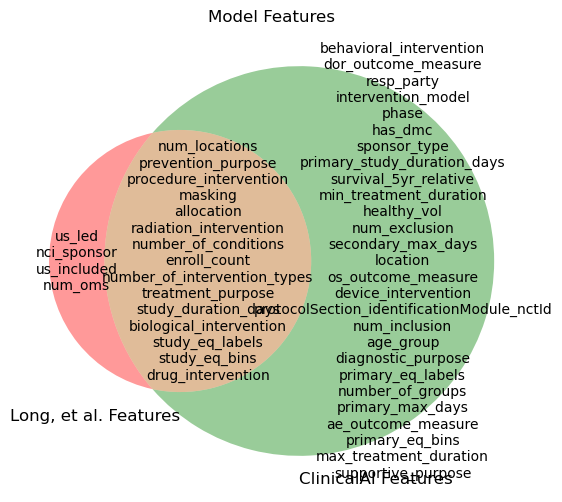

In [16]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Define your two lists of strings
list1 = [
        'study_duration_days',
        'study_eq_bins',
        'study_eq_labels',
        'num_oms',
        'masking',
        'number_of_intervention_types',
        "num_locations",
        'number_of_conditions',
        'allocation',
        'masking',
        'enroll_count',
        'biological_intervention',
        'procedure_intervention',
        'drug_intervention',
        'radiation_intervention',
        'treatment_purpose',
        'prevention_purpose',
        'us_led',
        'us_included',
        'nci_sponsor'
    ]
list2 = [
        'protocolSection_identificationModule_nctId',
        'primary_study_duration_days',
        'study_duration_days',
        'primary_eq_bins',
        'study_eq_bins',
        'study_eq_labels',
        'primary_eq_labels',
        'number_of_conditions',
        'number_of_groups',
        'age_group',
        'num_locations',
        'location',
        'num_inclusion',
        'num_exclusion',
        # 'intervention_types',
        'number_of_intervention_types',
        'sponsor_type',
        'intervention_model',
        'resp_party',
        'has_dmc',
        'phase',
        'allocation',
        'masking',
        'enroll_count',
        'healthy_vol',
        'treatment_purpose',
        'diagnostic_purpose',
        'prevention_purpose',
        'supportive_purpose',
        'procedure_intervention',
        'device_intervention',
        'behavioral_intervention',
        'drug_intervention',
        'radiation_intervention',
        'biological_intervention',
        'os_outcome_measure',
        'dor_outcome_measure',
        'ae_outcome_measure',
        'primary_max_days',
        'secondary_max_days',
        'max_treatment_duration',
        'min_treatment_duration',
        'survival_5yr_relative',
        # 'conditions_category_num'
        # 'protocolSection_outcomesModule_primaryOutcomes',
        # 'protocolSection_outcomesModule_secondaryOutcomes',
        # 'protocolSection_eligibilityModule_eligibilityCriteria'
    ]


# Convert lists to sets and get unique and common items
set1 = set(list1)
set2 = set(list2)
unique_to_list1 = set1 - set2
unique_to_list2 = set2 - set1
common_to_both = set1 & set2

# Create the Venn diagram
plt.figure(figsize=(8, 6))
venn = venn2([set1, set2], set_labels=('Long, et al. Features', 'ClinicalAI Features'))

# Update each section of the Venn with the items from each set
venn.get_label_by_id('10').set_text("\n".join(unique_to_list1))  # Unique to List 1
venn.get_label_by_id('01').set_text("\n".join(unique_to_list2))  # Unique to List 2
venn.get_label_by_id('11').set_text("\n".join(common_to_both))   # Common to both

# Display the plot
plt.title("Model Features")
plt.show()



In [52]:
# import spacy
from itertools import combinations

class DisjointSetUnion:
    def __init__(self):
        self.parent = {}
        self.rank = {}

    def find(self, item):
        if self.parent[item] != item:
            self.parent[item] = self.find(self.parent[item])
        return self.parent[item]

    def union(self, item1, item2):
        root1 = self.find(item1)
        root2 = self.find(item2)
        
        if root1 != root2:
            if self.rank[root1] > self.rank[root2]:
                self.parent[root2] = root1
            elif self.rank[root1] < self.rank[root2]:
                self.parent[root1] = root2
            else:
                self.parent[root2] = root1
                self.rank[root1] += 1

    def add(self, item):
        if item not in self.parent:
            self.parent[item] = item
            self.rank[item] = 0




In [54]:
def group_similar_terms(terms, text, similarity_threshold=0.8):
    dsu = DisjointSetUnion()

    # Process the text with spaCy
    doc = nlp(text)

    # Create a spaCy document for each term to compare
    term_docs = {term: nlp(term) for term in terms}

    # Add terms to DSU
    for term in terms:
        dsu.add(term)

    # Compare terms against each other for similarity
    for term1, term2 in combinations(terms, 2):
        similarity = term_docs[term1].similarity(term_docs[term2])
        if similarity >= similarity_threshold:
            dsu.union(term1, term2)

    # Create groups based on the DSU
    groups = {}
    for term in terms:
        root = dsu.find(term)
        if root not in groups:
            groups[root] = []
        groups[root].append(term)

    return groups

In [14]:
term_to_compare = terms[0]
df['similarity'] = df['protocolSection_outcomesModule_primaryOutcomes'].astype(str).apply(lambda x: compute_similarity(term_to_compare, x))
df

,protocolSection_identificationModule_nctId,protocolSection_identificationModule_orgStudyIdInfo_id,protocolSection_identificationModule_organization_fullName,protocolSection_identificationModule_organization_class,protocolSection_identificationModule_briefTitle,protocolSection_identificationModule_officialTitle,protocolSection_statusModule_statusVerifiedDate,protocolSection_statusModule_overallStatus,protocolSection_statusModule_expandedAccessInfo_hasExpandedAccess,protocolSection_statusModule_startDateStruct_date,...,protocolSection_statusModule_dispFirstPostDateStruct_type,protocolSection_outcomesModule_otherOutcomes,protocolSection_designModule_designInfo_maskingInfo_whoMasked,protocolSection_oversightModule_isUsExport,protocolSection_designModule_designInfo_maskingInfo_maskingDescription,protocolSection_referencesModule_availIpds,protocolSection_statusModule_expandedAccessInfo_nctId,protocolSection_statusModule_expandedAccessInfo_statusForNctId,protocolSection_oversightModule_isUnapprovedDevice,similarity
0,NCT03316144,Junshi-JS001-011,"Shanghai Junshi Bioscience Co., Ltd.",OTHER,"Safety, Tolerability, Pharmacokinetics & Pharm...","A Phase I Study of Safety, Tolerability, Pharm...",2020-09,COMPLETED,False,2017-07-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.379698
1,NCT01212341,MG4101_P1,Seoul National University Hospital,OTHER,Allogeneic Natural Killer (NK) Cell Therapy in...,A Phase I Study of Allogeneic NK Cell Therapy ...,2013-08,COMPLETED,False,2010-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.381611
2,NCT01800630,HR-12-001,InnoPharmax Inc.,INDUSTRY,Phase1 Study of Gemcitabine HCl Oral Formulati...,"An Open Label, Phase 1, Dose Escalation Study ...",2019-07,COMPLETED,False,2013-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.441973
3,NCT01065025,4SC-205-1-2009,4SC AG,INDUSTRY,"Open Label, Dose Escalation Trial of Oral Eg5 ...","Open Label, Dose Escalation Trial of Oral 4SC-...",2015-04,COMPLETED,False,2010-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.396287
4,NCT01588548,D4510C00005,AstraZeneca,INDUSTRY,Global Phase1 Study to Assess the Safety and T...,"A Phase I, Open-Label, Multicentre Study to As...",2015-10,COMPLETED,False,2012-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.635230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,NCT00004910,NU 98CC2,Northwestern University,OTHER,Endoscopic Placement of Metal Stents in Treati...,A Pilot Phase I/II Trial of Enteral Wallstents...,2012-05,COMPLETED,False,2000-01,...,ESTIMATED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.126607
1096,NCT00654160,CDR0000592931,Mayo Clinic,OTHER,"Irinotecan, Fluorouracil, and Leucovorin in Tr...",A Pharmacogenetic-Based Phase I Trial of Irino...,2016-09,COMPLETED,False,2008-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.443009
1097,NCT00003867,CDR0000067031,Montefiore Medical Center,OTHER,Irinotecan and Capecitabine in Treating Patien...,Phase I Clinical Study of Every Three Week Iri...,2018-09,COMPLETED,False,1999-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.126607
1098,NCT00397384,NCI-2009-00107,National Cancer Institute (NCI),NIH,Erlotinib Hydrochloride and Cetuximab in Treat...,A Phase I Clinical and Biological Evaluation o...,2014-02,COMPLETED,False,2007-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.494792


In [5]:
x = [i for i in df.columns if 'keyword' in i]
x

['protocolSection_conditionsModule_keywords']

In [6]:
df['protocolSection_conditionsModule_keywords']

0       [immunotherapy, check point inhibitor, PD-1 an...
1         [Allogenetic NK cells, Lymphomas, Solid tumors]
2                                                     NaN
3             [4SC-205, Solid tumors, Lymphomas, Phase I]
4       [Advanced solid malignancies, Malignant lymphoma]
                              ...                        
1095    [stage I colon cancer, stage II colon cancer, ...
1096    [stage IIIB anal cancer, stage IV anal cancer,...
1097    [stage III colon cancer, stage IV colon cancer...
1098                                                  NaN
1099    [Coronavirus Disease, Creatine phosphokinase, ...
Name: protocolSection_conditionsModule_keywords, Length: 1100, dtype: object

In [8]:
df['start_date'] = df['protocolSection_statusModule_startDateStruct_date'].apply(convert_to_datetime)
df['primary_completion_date'] = df['protocolSection_statusModule_primaryCompletionDateStruct_date'].apply(convert_to_datetime)
df['completion_date'] = df['protocolSection_statusModule_completionDateStruct_date'].apply(convert_to_datetime)
df['primary_study_duration_days'] = (df['primary_completion_date'] - df['start_date']).dt.days
df['study_duration_days'] = (df['completion_date'] - df['start_date']).dt.days

df

,protocolSection_identificationModule_nctId,protocolSection_identificationModule_orgStudyIdInfo_id,protocolSection_identificationModule_organization_fullName,protocolSection_identificationModule_organization_class,protocolSection_identificationModule_briefTitle,protocolSection_identificationModule_officialTitle,protocolSection_statusModule_statusVerifiedDate,protocolSection_statusModule_overallStatus,protocolSection_statusModule_expandedAccessInfo_hasExpandedAccess,protocolSection_statusModule_startDateStruct_date,...,protocolSection_designModule_designInfo_maskingInfo_maskingDescription,protocolSection_referencesModule_availIpds,protocolSection_statusModule_expandedAccessInfo_nctId,protocolSection_statusModule_expandedAccessInfo_statusForNctId,protocolSection_oversightModule_isUnapprovedDevice,start_date,primary_completion_date,completion_date,primary_study_duration_days,study_duration_days
0,NCT03316144,Junshi-JS001-011,"Shanghai Junshi Bioscience Co., Ltd.",OTHER,"Safety, Tolerability, Pharmacokinetics & Pharm...","A Phase I Study of Safety, Tolerability, Pharm...",2020-09,COMPLETED,False,2017-07-12,...,NaN,NaN,NaN,NaN,NaN,2017-07-12,2018-09-15,2019-12-30,430.0,901.0
1,NCT01212341,MG4101_P1,Seoul National University Hospital,OTHER,Allogeneic Natural Killer (NK) Cell Therapy in...,A Phase I Study of Allogeneic NK Cell Therapy ...,2013-08,COMPLETED,False,2010-09,...,NaN,NaN,NaN,NaN,NaN,2010-09-01,2012-08-01,2013-03-01,700.0,912.0
2,NCT01800630,HR-12-001,InnoPharmax Inc.,INDUSTRY,Phase1 Study of Gemcitabine HCl Oral Formulati...,"An Open Label, Phase 1, Dose Escalation Study ...",2019-07,COMPLETED,False,2013-04,...,NaN,NaN,NaN,NaN,NaN,2013-04-01,2015-11-01,2016-03-01,944.0,1065.0
3,NCT01065025,4SC-205-1-2009,4SC AG,INDUSTRY,"Open Label, Dose Escalation Trial of Oral Eg5 ...","Open Label, Dose Escalation Trial of Oral 4SC-...",2015-04,COMPLETED,False,2010-01,...,NaN,NaN,NaN,NaN,NaN,2010-01-01,2015-04-01,2015-04-01,1916.0,1916.0
4,NCT01588548,D4510C00005,AstraZeneca,INDUSTRY,Global Phase1 Study to Assess the Safety and T...,"A Phase I, Open-Label, Multicentre Study to As...",2015-10,COMPLETED,False,2012-07,...,NaN,NaN,NaN,NaN,NaN,2012-07-01,2014-07-01,2014-07-01,730.0,730.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,NCT00004910,NU 98CC2,Northwestern University,OTHER,Endoscopic Placement of Metal Stents in Treati...,A Pilot Phase I/II Trial of Enteral Wallstents...,2012-05,COMPLETED,False,2000-01,...,NaN,NaN,NaN,NaN,NaN,2000-01-01,2003-02-01,2003-02-01,1127.0,1127.0
1096,NCT00654160,CDR0000592931,Mayo Clinic,OTHER,"Irinotecan, Fluorouracil, and Leucovorin in Tr...",A Pharmacogenetic-Based Phase I Trial of Irino...,2016-09,COMPLETED,False,2008-06,...,NaN,NaN,NaN,NaN,NaN,2008-06-01,2010-11-01,2012-12-03,883.0,1646.0
1097,NCT00003867,CDR0000067031,Montefiore Medical Center,OTHER,Irinotecan and Capecitabine in Treating Patien...,Phase I Clinical Study of Every Three Week Iri...,2018-09,COMPLETED,False,1999-03,...,NaN,NaN,NaN,NaN,NaN,1999-03-01,2003-03-01,2003-03-01,1461.0,1461.0
1098,NCT00397384,NCI-2009-00107,National Cancer Institute (NCI),NIH,Erlotinib Hydrochloride and Cetuximab in Treat...,A Phase I Clinical and Biological Evaluation o...,2014-02,COMPLETED,False,2007-01,...,NaN,NaN,NaN,NaN,NaN,2007-01-01,2013-06-01,2013-06-01,2343.0,2343.0


In [9]:
#avg trial duration
avg_dur = np.mean(df['study_duration_days'])
avg_dur

1786.860655737705

In [11]:
df['study_eq_bins'] = pd.cut(df['study_duration_days'], bins=[df['study_duration_days'].min(), avg_dur, df['study_duration_days'].max()], labels=['Low', 'High'], right=False)

df['study_eq_labels'] = df['study_eq_bins'].cat.codes

df

,protocolSection_identificationModule_nctId,protocolSection_identificationModule_orgStudyIdInfo_id,protocolSection_identificationModule_organization_fullName,protocolSection_identificationModule_organization_class,protocolSection_identificationModule_briefTitle,protocolSection_identificationModule_officialTitle,protocolSection_statusModule_statusVerifiedDate,protocolSection_statusModule_overallStatus,protocolSection_statusModule_expandedAccessInfo_hasExpandedAccess,protocolSection_statusModule_startDateStruct_date,...,protocolSection_statusModule_expandedAccessInfo_nctId,protocolSection_statusModule_expandedAccessInfo_statusForNctId,protocolSection_oversightModule_isUnapprovedDevice,start_date,primary_completion_date,completion_date,primary_study_duration_days,study_duration_days,study_eq_bins,study_eq_labels
0,NCT03316144,Junshi-JS001-011,"Shanghai Junshi Bioscience Co., Ltd.",OTHER,"Safety, Tolerability, Pharmacokinetics & Pharm...","A Phase I Study of Safety, Tolerability, Pharm...",2020-09,COMPLETED,False,2017-07-12,...,NaN,NaN,NaN,2017-07-12,2018-09-15,2019-12-30,430.0,901.0,Low,0
1,NCT01212341,MG4101_P1,Seoul National University Hospital,OTHER,Allogeneic Natural Killer (NK) Cell Therapy in...,A Phase I Study of Allogeneic NK Cell Therapy ...,2013-08,COMPLETED,False,2010-09,...,NaN,NaN,NaN,2010-09-01,2012-08-01,2013-03-01,700.0,912.0,Low,0
2,NCT01800630,HR-12-001,InnoPharmax Inc.,INDUSTRY,Phase1 Study of Gemcitabine HCl Oral Formulati...,"An Open Label, Phase 1, Dose Escalation Study ...",2019-07,COMPLETED,False,2013-04,...,NaN,NaN,NaN,2013-04-01,2015-11-01,2016-03-01,944.0,1065.0,Low,0
3,NCT01065025,4SC-205-1-2009,4SC AG,INDUSTRY,"Open Label, Dose Escalation Trial of Oral Eg5 ...","Open Label, Dose Escalation Trial of Oral 4SC-...",2015-04,COMPLETED,False,2010-01,...,NaN,NaN,NaN,2010-01-01,2015-04-01,2015-04-01,1916.0,1916.0,High,1
4,NCT01588548,D4510C00005,AstraZeneca,INDUSTRY,Global Phase1 Study to Assess the Safety and T...,"A Phase I, Open-Label, Multicentre Study to As...",2015-10,COMPLETED,False,2012-07,...,NaN,NaN,NaN,2012-07-01,2014-07-01,2014-07-01,730.0,730.0,Low,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,NCT00004910,NU 98CC2,Northwestern University,OTHER,Endoscopic Placement of Metal Stents in Treati...,A Pilot Phase I/II Trial of Enteral Wallstents...,2012-05,COMPLETED,False,2000-01,...,NaN,NaN,NaN,2000-01-01,2003-02-01,2003-02-01,1127.0,1127.0,Low,0
1096,NCT00654160,CDR0000592931,Mayo Clinic,OTHER,"Irinotecan, Fluorouracil, and Leucovorin in Tr...",A Pharmacogenetic-Based Phase I Trial of Irino...,2016-09,COMPLETED,False,2008-06,...,NaN,NaN,NaN,2008-06-01,2010-11-01,2012-12-03,883.0,1646.0,Low,0
1097,NCT00003867,CDR0000067031,Montefiore Medical Center,OTHER,Irinotecan and Capecitabine in Treating Patien...,Phase I Clinical Study of Every Three Week Iri...,2018-09,COMPLETED,False,1999-03,...,NaN,NaN,NaN,1999-03-01,2003-03-01,2003-03-01,1461.0,1461.0,Low,0
1098,NCT00397384,NCI-2009-00107,National Cancer Institute (NCI),NIH,Erlotinib Hydrochloride and Cetuximab in Treat...,A Phase I Clinical and Biological Evaluation o...,2014-02,COMPLETED,False,2007-01,...,NaN,NaN,NaN,2007-01-01,2013-06-01,2013-06-01,2343.0,2343.0,High,1


In [12]:
oms = [col for col in df.columns if "outcome" in col]
oms

['protocolSection_outcomesModule_primaryOutcomes',
 'protocolSection_outcomesModule_secondaryOutcomes',
 'protocolSection_outcomesModule_otherOutcomes']

In [22]:
def list_to_lower_string(lst):
    # Ensure the input is a list
    if isinstance(lst, list):
        # Convert each element to a lowercase string and join with spaces
        return ", ".join(map(str, lst)).lower()

In [26]:
for i in oms:
    df[i].apply(list_to_lower_string)
    df[f"num_{i}"] = df[i].apply(lambda x: len(x) if isinstance(x, list) else 0)
df

,protocolSection_identificationModule_nctId,protocolSection_identificationModule_orgStudyIdInfo_id,protocolSection_identificationModule_organization_fullName,protocolSection_identificationModule_organization_class,protocolSection_identificationModule_briefTitle,protocolSection_identificationModule_officialTitle,protocolSection_statusModule_statusVerifiedDate,protocolSection_statusModule_overallStatus,protocolSection_statusModule_expandedAccessInfo_hasExpandedAccess,protocolSection_statusModule_startDateStruct_date,...,start_date,primary_completion_date,completion_date,primary_study_duration_days,study_duration_days,study_eq_bins,study_eq_labels,num_protocolSection_outcomesModule_primaryOutcomes,num_protocolSection_outcomesModule_secondaryOutcomes,num_protocolSection_outcomesModule_otherOutcomes
0,NCT03316144,Junshi-JS001-011,"Shanghai Junshi Bioscience Co., Ltd.",OTHER,"Safety, Tolerability, Pharmacokinetics & Pharm...","A Phase I Study of Safety, Tolerability, Pharm...",2020-09,COMPLETED,False,2017-07-12,...,2017-07-12,2018-09-15,2019-12-30,430.0,901.0,Low,0,1,2,0
1,NCT01212341,MG4101_P1,Seoul National University Hospital,OTHER,Allogeneic Natural Killer (NK) Cell Therapy in...,A Phase I Study of Allogeneic NK Cell Therapy ...,2013-08,COMPLETED,False,2010-09,...,2010-09-01,2012-08-01,2013-03-01,700.0,912.0,Low,0,1,3,0
2,NCT01800630,HR-12-001,InnoPharmax Inc.,INDUSTRY,Phase1 Study of Gemcitabine HCl Oral Formulati...,"An Open Label, Phase 1, Dose Escalation Study ...",2019-07,COMPLETED,False,2013-04,...,2013-04-01,2015-11-01,2016-03-01,944.0,1065.0,Low,0,1,4,0
3,NCT01065025,4SC-205-1-2009,4SC AG,INDUSTRY,"Open Label, Dose Escalation Trial of Oral Eg5 ...","Open Label, Dose Escalation Trial of Oral 4SC-...",2015-04,COMPLETED,False,2010-01,...,2010-01-01,2015-04-01,2015-04-01,1916.0,1916.0,High,1,1,3,0
4,NCT01588548,D4510C00005,AstraZeneca,INDUSTRY,Global Phase1 Study to Assess the Safety and T...,"A Phase I, Open-Label, Multicentre Study to As...",2015-10,COMPLETED,False,2012-07,...,2012-07-01,2014-07-01,2014-07-01,730.0,730.0,Low,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,NCT00004910,NU 98CC2,Northwestern University,OTHER,Endoscopic Placement of Metal Stents in Treati...,A Pilot Phase I/II Trial of Enteral Wallstents...,2012-05,COMPLETED,False,2000-01,...,2000-01-01,2003-02-01,2003-02-01,1127.0,1127.0,Low,0,0,0,0
1096,NCT00654160,CDR0000592931,Mayo Clinic,OTHER,"Irinotecan, Fluorouracil, and Leucovorin in Tr...",A Pharmacogenetic-Based Phase I Trial of Irino...,2016-09,COMPLETED,False,2008-06,...,2008-06-01,2010-11-01,2012-12-03,883.0,1646.0,Low,0,1,1,0
1097,NCT00003867,CDR0000067031,Montefiore Medical Center,OTHER,Irinotecan and Capecitabine in Treating Patien...,Phase I Clinical Study of Every Three Week Iri...,2018-09,COMPLETED,False,1999-03,...,1999-03-01,2003-03-01,2003-03-01,1461.0,1461.0,Low,0,0,0,0
1098,NCT00397384,NCI-2009-00107,National Cancer Institute (NCI),NIH,Erlotinib Hydrochloride and Cetuximab in Treat...,A Phase I Clinical and Biological Evaluation o...,2014-02,COMPLETED,False,2007-01,...,2007-01-01,2013-06-01,2013-06-01,2343.0,2343.0,High,1,2,3,0


In [27]:
num_om_cols = [col for col in df.columns if "num" in col and "outcome" in col]
num_om_cols

['num_protocolSection_outcomesModule_primaryOutcomes',
 'num_protocolSection_outcomesModule_secondaryOutcomes',
 'num_protocolSection_outcomesModule_otherOutcomes']

In [28]:
df['num_oms'] = df[num_om_cols].sum(axis=1)
df

,protocolSection_identificationModule_nctId,protocolSection_identificationModule_orgStudyIdInfo_id,protocolSection_identificationModule_organization_fullName,protocolSection_identificationModule_organization_class,protocolSection_identificationModule_briefTitle,protocolSection_identificationModule_officialTitle,protocolSection_statusModule_statusVerifiedDate,protocolSection_statusModule_overallStatus,protocolSection_statusModule_expandedAccessInfo_hasExpandedAccess,protocolSection_statusModule_startDateStruct_date,...,primary_completion_date,completion_date,primary_study_duration_days,study_duration_days,study_eq_bins,study_eq_labels,num_protocolSection_outcomesModule_primaryOutcomes,num_protocolSection_outcomesModule_secondaryOutcomes,num_protocolSection_outcomesModule_otherOutcomes,num_oms
0,NCT03316144,Junshi-JS001-011,"Shanghai Junshi Bioscience Co., Ltd.",OTHER,"Safety, Tolerability, Pharmacokinetics & Pharm...","A Phase I Study of Safety, Tolerability, Pharm...",2020-09,COMPLETED,False,2017-07-12,...,2018-09-15,2019-12-30,430.0,901.0,Low,0,1,2,0,3
1,NCT01212341,MG4101_P1,Seoul National University Hospital,OTHER,Allogeneic Natural Killer (NK) Cell Therapy in...,A Phase I Study of Allogeneic NK Cell Therapy ...,2013-08,COMPLETED,False,2010-09,...,2012-08-01,2013-03-01,700.0,912.0,Low,0,1,3,0,4
2,NCT01800630,HR-12-001,InnoPharmax Inc.,INDUSTRY,Phase1 Study of Gemcitabine HCl Oral Formulati...,"An Open Label, Phase 1, Dose Escalation Study ...",2019-07,COMPLETED,False,2013-04,...,2015-11-01,2016-03-01,944.0,1065.0,Low,0,1,4,0,5
3,NCT01065025,4SC-205-1-2009,4SC AG,INDUSTRY,"Open Label, Dose Escalation Trial of Oral Eg5 ...","Open Label, Dose Escalation Trial of Oral 4SC-...",2015-04,COMPLETED,False,2010-01,...,2015-04-01,2015-04-01,1916.0,1916.0,High,1,1,3,0,4
4,NCT01588548,D4510C00005,AstraZeneca,INDUSTRY,Global Phase1 Study to Assess the Safety and T...,"A Phase I, Open-Label, Multicentre Study to As...",2015-10,COMPLETED,False,2012-07,...,2014-07-01,2014-07-01,730.0,730.0,Low,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,NCT00004910,NU 98CC2,Northwestern University,OTHER,Endoscopic Placement of Metal Stents in Treati...,A Pilot Phase I/II Trial of Enteral Wallstents...,2012-05,COMPLETED,False,2000-01,...,2003-02-01,2003-02-01,1127.0,1127.0,Low,0,0,0,0,0
1096,NCT00654160,CDR0000592931,Mayo Clinic,OTHER,"Irinotecan, Fluorouracil, and Leucovorin in Tr...",A Pharmacogenetic-Based Phase I Trial of Irino...,2016-09,COMPLETED,False,2008-06,...,2010-11-01,2012-12-03,883.0,1646.0,Low,0,1,1,0,2
1097,NCT00003867,CDR0000067031,Montefiore Medical Center,OTHER,Irinotecan and Capecitabine in Treating Patien...,Phase I Clinical Study of Every Three Week Iri...,2018-09,COMPLETED,False,1999-03,...,2003-03-01,2003-03-01,1461.0,1461.0,Low,0,0,0,0,0
1098,NCT00397384,NCI-2009-00107,National Cancer Institute (NCI),NIH,Erlotinib Hydrochloride and Cetuximab in Treat...,A Phase I Clinical and Biological Evaluation o...,2014-02,COMPLETED,False,2007-01,...,2013-06-01,2013-06-01,2343.0,2343.0,High,1,2,3,0,5


In [30]:
cols = [col for col in df.columns if "nci" in col]
cols

[]

In [31]:
df['protocolSection_armsInterventionsModule_interventions']

0       [{'type': 'BIOLOGICAL', 'name': 'Toripalimab',...
1       [{'type': 'BIOLOGICAL', 'name': 'Allogeneic NK...
2       [{'type': 'DRUG', 'name': 'Gemcitabine HCl Ora...
3       [{'type': 'DRUG', 'name': '4SC-205', 'descript...
4       [{'type': 'DRUG', 'name': 'AZD1208', 'descript...
                              ...                        
1095    [{'type': 'PROCEDURE', 'name': 'bowel obstruct...
1096    [{'type': 'DRUG', 'name': 'fluorouracil'}, {'t...
1097    [{'type': 'DRUG', 'name': 'capecitabine'}, {'t...
1098    [{'type': 'DRUG', 'name': 'cetuximab', 'descri...
1099    [{'type': 'BIOLOGICAL', 'name': 'cAd3-Marburg'...
Name: protocolSection_armsInterventionsModule_interventions, Length: 1100, dtype: object

In [32]:
df['protocolSection_conditionsModule_conditions']

0                                    [Malignant Lymphoma]
1                     [Malignant Lymphomas, Solid Tumors]
2       [Advanced Solid Malignancies, Malignant Lympho...
3       [Advanced and Incurable Solid Tumors, Malignan...
4       [Advanced Solid Malignancies, Malignant Lymphoma]
                              ...                        
1095    [Colorectal Cancer, Constipation, Impaction, a...
1096    [Anal Cancer, Carcinoma of the Appendix, Color...
1097                                             [Cancer]
1098    [Adenocarcinoma of the Colon, Adenocarcinoma o...
1099         [Ebola Virus Disease, Marburg Virus Disease]
Name: protocolSection_conditionsModule_conditions, Length: 1100, dtype: object

In [33]:
df['us_included'] = df["protocolSection_contactsLocationsModule_locations"].astype(str).apply(lambda x: True if x == "USA" or x == "USA & non-USA" else False)

df

,protocolSection_identificationModule_nctId,protocolSection_identificationModule_orgStudyIdInfo_id,protocolSection_identificationModule_organization_fullName,protocolSection_identificationModule_organization_class,protocolSection_identificationModule_briefTitle,protocolSection_identificationModule_officialTitle,protocolSection_statusModule_statusVerifiedDate,protocolSection_statusModule_overallStatus,protocolSection_statusModule_expandedAccessInfo_hasExpandedAccess,protocolSection_statusModule_startDateStruct_date,...,completion_date,primary_study_duration_days,study_duration_days,study_eq_bins,study_eq_labels,num_protocolSection_outcomesModule_primaryOutcomes,num_protocolSection_outcomesModule_secondaryOutcomes,num_protocolSection_outcomesModule_otherOutcomes,num_oms,us_included
0,NCT03316144,Junshi-JS001-011,"Shanghai Junshi Bioscience Co., Ltd.",OTHER,"Safety, Tolerability, Pharmacokinetics & Pharm...","A Phase I Study of Safety, Tolerability, Pharm...",2020-09,COMPLETED,False,2017-07-12,...,2019-12-30,430.0,901.0,Low,0,1,2,0,3,False
1,NCT01212341,MG4101_P1,Seoul National University Hospital,OTHER,Allogeneic Natural Killer (NK) Cell Therapy in...,A Phase I Study of Allogeneic NK Cell Therapy ...,2013-08,COMPLETED,False,2010-09,...,2013-03-01,700.0,912.0,Low,0,1,3,0,4,False
2,NCT01800630,HR-12-001,InnoPharmax Inc.,INDUSTRY,Phase1 Study of Gemcitabine HCl Oral Formulati...,"An Open Label, Phase 1, Dose Escalation Study ...",2019-07,COMPLETED,False,2013-04,...,2016-03-01,944.0,1065.0,Low,0,1,4,0,5,False
3,NCT01065025,4SC-205-1-2009,4SC AG,INDUSTRY,"Open Label, Dose Escalation Trial of Oral Eg5 ...","Open Label, Dose Escalation Trial of Oral 4SC-...",2015-04,COMPLETED,False,2010-01,...,2015-04-01,1916.0,1916.0,High,1,1,3,0,4,False
4,NCT01588548,D4510C00005,AstraZeneca,INDUSTRY,Global Phase1 Study to Assess the Safety and T...,"A Phase I, Open-Label, Multicentre Study to As...",2015-10,COMPLETED,False,2012-07,...,2014-07-01,730.0,730.0,Low,0,1,0,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,NCT00004910,NU 98CC2,Northwestern University,OTHER,Endoscopic Placement of Metal Stents in Treati...,A Pilot Phase I/II Trial of Enteral Wallstents...,2012-05,COMPLETED,False,2000-01,...,2003-02-01,1127.0,1127.0,Low,0,0,0,0,0,False
1096,NCT00654160,CDR0000592931,Mayo Clinic,OTHER,"Irinotecan, Fluorouracil, and Leucovorin in Tr...",A Pharmacogenetic-Based Phase I Trial of Irino...,2016-09,COMPLETED,False,2008-06,...,2012-12-03,883.0,1646.0,Low,0,1,1,0,2,False
1097,NCT00003867,CDR0000067031,Montefiore Medical Center,OTHER,Irinotecan and Capecitabine in Treating Patien...,Phase I Clinical Study of Every Three Week Iri...,2018-09,COMPLETED,False,1999-03,...,2003-03-01,1461.0,1461.0,Low,0,0,0,0,0,False
1098,NCT00397384,NCI-2009-00107,National Cancer Institute (NCI),NIH,Erlotinib Hydrochloride and Cetuximab in Treat...,A Phase I Clinical and Biological Evaluation o...,2014-02,COMPLETED,False,2007-01,...,2013-06-01,2343.0,2343.0,High,1,2,3,0,5,False


In [36]:
df['us_included'] = df["protocolSection_contactsLocationsModule_locations"].astype(str).apply(trial_loc).apply(lambda x: True if x == "USA" or x == "USA & non-USA" else False)
df

,protocolSection_identificationModule_nctId,protocolSection_identificationModule_orgStudyIdInfo_id,protocolSection_identificationModule_organization_fullName,protocolSection_identificationModule_organization_class,protocolSection_identificationModule_briefTitle,protocolSection_identificationModule_officialTitle,protocolSection_statusModule_statusVerifiedDate,protocolSection_statusModule_overallStatus,protocolSection_statusModule_expandedAccessInfo_hasExpandedAccess,protocolSection_statusModule_startDateStruct_date,...,completion_date,primary_study_duration_days,study_duration_days,study_eq_bins,study_eq_labels,num_protocolSection_outcomesModule_primaryOutcomes,num_protocolSection_outcomesModule_secondaryOutcomes,num_protocolSection_outcomesModule_otherOutcomes,num_oms,us_included
0,NCT03316144,Junshi-JS001-011,"Shanghai Junshi Bioscience Co., Ltd.",OTHER,"Safety, Tolerability, Pharmacokinetics & Pharm...","A Phase I Study of Safety, Tolerability, Pharm...",2020-09,COMPLETED,False,2017-07-12,...,2019-12-30,430.0,901.0,Low,0,1,2,0,3,False
1,NCT01212341,MG4101_P1,Seoul National University Hospital,OTHER,Allogeneic Natural Killer (NK) Cell Therapy in...,A Phase I Study of Allogeneic NK Cell Therapy ...,2013-08,COMPLETED,False,2010-09,...,2013-03-01,700.0,912.0,Low,0,1,3,0,4,False
2,NCT01800630,HR-12-001,InnoPharmax Inc.,INDUSTRY,Phase1 Study of Gemcitabine HCl Oral Formulati...,"An Open Label, Phase 1, Dose Escalation Study ...",2019-07,COMPLETED,False,2013-04,...,2016-03-01,944.0,1065.0,Low,0,1,4,0,5,False
3,NCT01065025,4SC-205-1-2009,4SC AG,INDUSTRY,"Open Label, Dose Escalation Trial of Oral Eg5 ...","Open Label, Dose Escalation Trial of Oral 4SC-...",2015-04,COMPLETED,False,2010-01,...,2015-04-01,1916.0,1916.0,High,1,1,3,0,4,False
4,NCT01588548,D4510C00005,AstraZeneca,INDUSTRY,Global Phase1 Study to Assess the Safety and T...,"A Phase I, Open-Label, Multicentre Study to As...",2015-10,COMPLETED,False,2012-07,...,2014-07-01,730.0,730.0,Low,0,1,0,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,NCT00004910,NU 98CC2,Northwestern University,OTHER,Endoscopic Placement of Metal Stents in Treati...,A Pilot Phase I/II Trial of Enteral Wallstents...,2012-05,COMPLETED,False,2000-01,...,2003-02-01,1127.0,1127.0,Low,0,0,0,0,0,True
1096,NCT00654160,CDR0000592931,Mayo Clinic,OTHER,"Irinotecan, Fluorouracil, and Leucovorin in Tr...",A Pharmacogenetic-Based Phase I Trial of Irino...,2016-09,COMPLETED,False,2008-06,...,2012-12-03,883.0,1646.0,Low,0,1,1,0,2,True
1097,NCT00003867,CDR0000067031,Montefiore Medical Center,OTHER,Irinotecan and Capecitabine in Treating Patien...,Phase I Clinical Study of Every Three Week Iri...,2018-09,COMPLETED,False,1999-03,...,2003-03-01,1461.0,1461.0,Low,0,0,0,0,0,True
1098,NCT00397384,NCI-2009-00107,National Cancer Institute (NCI),NIH,Erlotinib Hydrochloride and Cetuximab in Treat...,A Phase I Clinical and Biological Evaluation o...,2014-02,COMPLETED,False,2007-01,...,2013-06-01,2343.0,2343.0,High,1,2,3,0,5,True


In [40]:
df['location0'] = df["protocolSection_contactsLocationsModule_locations"].astype(str).apply(trial_loc)
df['location0']

0       non-USA
1       non-USA
2       non-USA
3       non-USA
4       non-USA
         ...   
1095        USA
1096        USA
1097        USA
1098        USA
1099        USA
Name: location0, Length: 1100, dtype: object

In [41]:
df.loc[df['location0'] == "USA & non-USA", "protocolSection_contactsLocationsModule_locations"][:10]

11    [{'facility': 'Florida Cancer Specialists', 'c...
12    [{'facility': 'Florida Cancer Specialists', 'c...
15    [{'facility': 'Novartis Investigative Site', '...
17    [{'city': 'Goodyear', 'state': 'Arizona', 'cou...
21    [{'facility': 'The Cancer Institute of New Jer...
24    [{'facility': 'University of California San Fr...
25    [{'facility': 'Dana Farber Cancer Institute DF...
36    [{'facility': 'Banner Health', 'city': 'Gilber...
43    [{'facility': 'City of Hope National Medical C...
45    [{'facility': 'UCLA', 'city': 'Los Angeles', '...
Name: protocolSection_contactsLocationsModule_locations, dtype: object

In [46]:
x = df.loc[df['location0'] == "USA & non-USA", "protocolSection_contactsLocationsModule_locations"][15]

In [50]:
counter = {"USA": 0, "non-USA": 0}
for i in x:
    if i['country'] == 'United States':
        counter["USA"] += 1
    else:
        counter["non-USA"] += 1

if counter['USA'] > counter['non-USA']:
    print(True)
else:
    print(False)

False


In [60]:
def trial_loc_counter(value):
    # Initialize the counter
    counter = {"USA": 0, "non-USA": 0}
    
    # Check if the value is a list of dictionaries
    if isinstance(value, list):
        for i in value:
            if isinstance(i, dict) and 'country' in i:
                if i['country'] == 'United States':
                    counter["USA"] += 1
                else:
                    counter["non-USA"] += 1
        # Return True if USA has more counts than non-USA
        return counter['USA'] > counter['non-USA']
    else:
        # Return a default or handle the error case as appropriate
        return False

# Apply the function
df['us_led'] = df["protocolSection_contactsLocationsModule_locations"].apply(lambda x: trial_loc_counter(x))
df


,protocolSection_identificationModule_nctId,protocolSection_identificationModule_orgStudyIdInfo_id,protocolSection_identificationModule_organization_fullName,protocolSection_identificationModule_organization_class,protocolSection_identificationModule_briefTitle,protocolSection_identificationModule_officialTitle,protocolSection_statusModule_statusVerifiedDate,protocolSection_statusModule_overallStatus,protocolSection_statusModule_expandedAccessInfo_hasExpandedAccess,protocolSection_statusModule_startDateStruct_date,...,study_duration_days,study_eq_bins,study_eq_labels,num_protocolSection_outcomesModule_primaryOutcomes,num_protocolSection_outcomesModule_secondaryOutcomes,num_protocolSection_outcomesModule_otherOutcomes,num_oms,us_included,location0,us_led
0,NCT03316144,Junshi-JS001-011,"Shanghai Junshi Bioscience Co., Ltd.",OTHER,"Safety, Tolerability, Pharmacokinetics & Pharm...","A Phase I Study of Safety, Tolerability, Pharm...",2020-09,COMPLETED,False,2017-07-12,...,901.0,Low,0,1,2,0,3,False,non-USA,False
1,NCT01212341,MG4101_P1,Seoul National University Hospital,OTHER,Allogeneic Natural Killer (NK) Cell Therapy in...,A Phase I Study of Allogeneic NK Cell Therapy ...,2013-08,COMPLETED,False,2010-09,...,912.0,Low,0,1,3,0,4,False,non-USA,False
2,NCT01800630,HR-12-001,InnoPharmax Inc.,INDUSTRY,Phase1 Study of Gemcitabine HCl Oral Formulati...,"An Open Label, Phase 1, Dose Escalation Study ...",2019-07,COMPLETED,False,2013-04,...,1065.0,Low,0,1,4,0,5,False,non-USA,False
3,NCT01065025,4SC-205-1-2009,4SC AG,INDUSTRY,"Open Label, Dose Escalation Trial of Oral Eg5 ...","Open Label, Dose Escalation Trial of Oral 4SC-...",2015-04,COMPLETED,False,2010-01,...,1916.0,High,1,1,3,0,4,False,non-USA,False
4,NCT01588548,D4510C00005,AstraZeneca,INDUSTRY,Global Phase1 Study to Assess the Safety and T...,"A Phase I, Open-Label, Multicentre Study to As...",2015-10,COMPLETED,False,2012-07,...,730.0,Low,0,1,0,0,1,False,non-USA,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,NCT00004910,NU 98CC2,Northwestern University,OTHER,Endoscopic Placement of Metal Stents in Treati...,A Pilot Phase I/II Trial of Enteral Wallstents...,2012-05,COMPLETED,False,2000-01,...,1127.0,Low,0,0,0,0,0,True,USA,True
1096,NCT00654160,CDR0000592931,Mayo Clinic,OTHER,"Irinotecan, Fluorouracil, and Leucovorin in Tr...",A Pharmacogenetic-Based Phase I Trial of Irino...,2016-09,COMPLETED,False,2008-06,...,1646.0,Low,0,1,1,0,2,True,USA,True
1097,NCT00003867,CDR0000067031,Montefiore Medical Center,OTHER,Irinotecan and Capecitabine in Treating Patien...,Phase I Clinical Study of Every Three Week Iri...,2018-09,COMPLETED,False,1999-03,...,1461.0,Low,0,0,0,0,0,True,USA,True
1098,NCT00397384,NCI-2009-00107,National Cancer Institute (NCI),NIH,Erlotinib Hydrochloride and Cetuximab in Treat...,A Phase I Clinical and Biological Evaluation o...,2014-02,COMPLETED,False,2007-01,...,2343.0,High,1,2,3,0,5,True,USA,True


In [59]:
df['us_led'] = df["protocolSection_contactsLocationsModule_locations"].apply(trial_loc_counter)

df

,protocolSection_identificationModule_nctId,protocolSection_identificationModule_orgStudyIdInfo_id,protocolSection_identificationModule_organization_fullName,protocolSection_identificationModule_organization_class,protocolSection_identificationModule_briefTitle,protocolSection_identificationModule_officialTitle,protocolSection_statusModule_statusVerifiedDate,protocolSection_statusModule_overallStatus,protocolSection_statusModule_expandedAccessInfo_hasExpandedAccess,protocolSection_statusModule_startDateStruct_date,...,study_duration_days,study_eq_bins,study_eq_labels,num_protocolSection_outcomesModule_primaryOutcomes,num_protocolSection_outcomesModule_secondaryOutcomes,num_protocolSection_outcomesModule_otherOutcomes,num_oms,us_included,location0,us_led
0,NCT03316144,Junshi-JS001-011,"Shanghai Junshi Bioscience Co., Ltd.",OTHER,"Safety, Tolerability, Pharmacokinetics & Pharm...","A Phase I Study of Safety, Tolerability, Pharm...",2020-09,COMPLETED,False,2017-07-12,...,901.0,Low,0,1,2,0,3,False,non-USA,False
1,NCT01212341,MG4101_P1,Seoul National University Hospital,OTHER,Allogeneic Natural Killer (NK) Cell Therapy in...,A Phase I Study of Allogeneic NK Cell Therapy ...,2013-08,COMPLETED,False,2010-09,...,912.0,Low,0,1,3,0,4,False,non-USA,False
2,NCT01800630,HR-12-001,InnoPharmax Inc.,INDUSTRY,Phase1 Study of Gemcitabine HCl Oral Formulati...,"An Open Label, Phase 1, Dose Escalation Study ...",2019-07,COMPLETED,False,2013-04,...,1065.0,Low,0,1,4,0,5,False,non-USA,False
3,NCT01065025,4SC-205-1-2009,4SC AG,INDUSTRY,"Open Label, Dose Escalation Trial of Oral Eg5 ...","Open Label, Dose Escalation Trial of Oral 4SC-...",2015-04,COMPLETED,False,2010-01,...,1916.0,High,1,1,3,0,4,False,non-USA,False
4,NCT01588548,D4510C00005,AstraZeneca,INDUSTRY,Global Phase1 Study to Assess the Safety and T...,"A Phase I, Open-Label, Multicentre Study to As...",2015-10,COMPLETED,False,2012-07,...,730.0,Low,0,1,0,0,1,False,non-USA,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,NCT00004910,NU 98CC2,Northwestern University,OTHER,Endoscopic Placement of Metal Stents in Treati...,A Pilot Phase I/II Trial of Enteral Wallstents...,2012-05,COMPLETED,False,2000-01,...,1127.0,Low,0,0,0,0,0,True,USA,True
1096,NCT00654160,CDR0000592931,Mayo Clinic,OTHER,"Irinotecan, Fluorouracil, and Leucovorin in Tr...",A Pharmacogenetic-Based Phase I Trial of Irino...,2016-09,COMPLETED,False,2008-06,...,1646.0,Low,0,1,1,0,2,True,USA,True
1097,NCT00003867,CDR0000067031,Montefiore Medical Center,OTHER,Irinotecan and Capecitabine in Treating Patien...,Phase I Clinical Study of Every Three Week Iri...,2018-09,COMPLETED,False,1999-03,...,1461.0,Low,0,0,0,0,0,True,USA,True
1098,NCT00397384,NCI-2009-00107,National Cancer Institute (NCI),NIH,Erlotinib Hydrochloride and Cetuximab in Treat...,A Phase I Clinical and Biological Evaluation o...,2014-02,COMPLETED,False,2007-01,...,2343.0,High,1,2,3,0,5,True,USA,True


In [61]:
df['protocolSection_sponsorCollaboratorsModule_leadSponsor_class']

0          OTHER
1          OTHER
2       INDUSTRY
3       INDUSTRY
4       INDUSTRY
          ...   
1095       OTHER
1096       OTHER
1097       OTHER
1098         NIH
1099       OTHER
Name: protocolSection_sponsorCollaboratorsModule_leadSponsor_class, Length: 1100, dtype: object

In [62]:
df['protocolSection_sponsorCollaboratorsModule_responsibleParty_type']

0       SPONSOR
1           NaN
2       SPONSOR
3           NaN
4       SPONSOR
         ...   
1095    SPONSOR
1096    SPONSOR
1097    SPONSOR
1098    SPONSOR
1099    SPONSOR
Name: protocolSection_sponsorCollaboratorsModule_responsibleParty_type, Length: 1100, dtype: object

In [70]:
df['protocolSection_sponsorCollaboratorsModule_leadSponsor_name']

0       Shanghai Junshi Bioscience Co., Ltd.
1         Seoul National University Hospital
2                           InnoPharmax Inc.
3                                     4SC AG
4                                AstraZeneca
                        ...                 
1095                 Northwestern University
1096                             Mayo Clinic
1097               Montefiore Medical Center
1098         National Cancer Institute (NCI)
1099       Albert B. Sabin Vaccine Institute
Name: protocolSection_sponsorCollaboratorsModule_leadSponsor_name, Length: 1100, dtype: object

In [75]:
df.loc[df['protocolSection_sponsorCollaboratorsModule_leadSponsor_name']=="National Cancer Institute (NCI)", 'protocolSection_sponsorCollaboratorsModule_leadSponsor_name']

6       National Cancer Institute (NCI)
18      National Cancer Institute (NCI)
38      National Cancer Institute (NCI)
50      National Cancer Institute (NCI)
131     National Cancer Institute (NCI)
                     ...               
1022    National Cancer Institute (NCI)
1076    National Cancer Institute (NCI)
1088    National Cancer Institute (NCI)
1092    National Cancer Institute (NCI)
1098    National Cancer Institute (NCI)
Name: protocolSection_sponsorCollaboratorsModule_leadSponsor_name, Length: 74, dtype: object

In [76]:
df['nci_sponsor'] = df['protocolSection_sponsorCollaboratorsModule_leadSponsor_name'].apply(lambda x: True if "National Cancer Institute (NCI)" in x else False)
df

,protocolSection_identificationModule_nctId,protocolSection_identificationModule_orgStudyIdInfo_id,protocolSection_identificationModule_organization_fullName,protocolSection_identificationModule_organization_class,protocolSection_identificationModule_briefTitle,protocolSection_identificationModule_officialTitle,protocolSection_statusModule_statusVerifiedDate,protocolSection_statusModule_overallStatus,protocolSection_statusModule_expandedAccessInfo_hasExpandedAccess,protocolSection_statusModule_startDateStruct_date,...,study_eq_bins,study_eq_labels,num_protocolSection_outcomesModule_primaryOutcomes,num_protocolSection_outcomesModule_secondaryOutcomes,num_protocolSection_outcomesModule_otherOutcomes,num_oms,us_included,location0,us_led,nci_sponsor
0,NCT03316144,Junshi-JS001-011,"Shanghai Junshi Bioscience Co., Ltd.",OTHER,"Safety, Tolerability, Pharmacokinetics & Pharm...","A Phase I Study of Safety, Tolerability, Pharm...",2020-09,COMPLETED,False,2017-07-12,...,Low,0,1,2,0,3,False,non-USA,False,False
1,NCT01212341,MG4101_P1,Seoul National University Hospital,OTHER,Allogeneic Natural Killer (NK) Cell Therapy in...,A Phase I Study of Allogeneic NK Cell Therapy ...,2013-08,COMPLETED,False,2010-09,...,Low,0,1,3,0,4,False,non-USA,False,False
2,NCT01800630,HR-12-001,InnoPharmax Inc.,INDUSTRY,Phase1 Study of Gemcitabine HCl Oral Formulati...,"An Open Label, Phase 1, Dose Escalation Study ...",2019-07,COMPLETED,False,2013-04,...,Low,0,1,4,0,5,False,non-USA,False,False
3,NCT01065025,4SC-205-1-2009,4SC AG,INDUSTRY,"Open Label, Dose Escalation Trial of Oral Eg5 ...","Open Label, Dose Escalation Trial of Oral 4SC-...",2015-04,COMPLETED,False,2010-01,...,High,1,1,3,0,4,False,non-USA,False,False
4,NCT01588548,D4510C00005,AstraZeneca,INDUSTRY,Global Phase1 Study to Assess the Safety and T...,"A Phase I, Open-Label, Multicentre Study to As...",2015-10,COMPLETED,False,2012-07,...,Low,0,1,0,0,1,False,non-USA,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,NCT00004910,NU 98CC2,Northwestern University,OTHER,Endoscopic Placement of Metal Stents in Treati...,A Pilot Phase I/II Trial of Enteral Wallstents...,2012-05,COMPLETED,False,2000-01,...,Low,0,0,0,0,0,True,USA,True,False
1096,NCT00654160,CDR0000592931,Mayo Clinic,OTHER,"Irinotecan, Fluorouracil, and Leucovorin in Tr...",A Pharmacogenetic-Based Phase I Trial of Irino...,2016-09,COMPLETED,False,2008-06,...,Low,0,1,1,0,2,True,USA,True,False
1097,NCT00003867,CDR0000067031,Montefiore Medical Center,OTHER,Irinotecan and Capecitabine in Treating Patien...,Phase I Clinical Study of Every Three Week Iri...,2018-09,COMPLETED,False,1999-03,...,Low,0,0,0,0,0,True,USA,True,False
1098,NCT00397384,NCI-2009-00107,National Cancer Institute (NCI),NIH,Erlotinib Hydrochloride and Cetuximab in Treat...,A Phase I Clinical and Biological Evaluation o...,2014-02,COMPLETED,False,2007-01,...,High,1,2,3,0,5,True,USA,True,True


In [80]:
def check_crossover(item):
    if isinstance(item, str):  # Ensure item is a string
        # Check if "CROSSOVER" is in the string
        return "CROSSOVER" in item.upper()  # Convert to uppercase for case-insensitive check
    return False  # Return False if item is not a string

# Apply the check_crossover function to the desired column
df['crossover'] = df['protocolSection_designModule_designInfo_interventionModel'].apply(check_crossover)
df

,protocolSection_identificationModule_nctId,protocolSection_identificationModule_orgStudyIdInfo_id,protocolSection_identificationModule_organization_fullName,protocolSection_identificationModule_organization_class,protocolSection_identificationModule_briefTitle,protocolSection_identificationModule_officialTitle,protocolSection_statusModule_statusVerifiedDate,protocolSection_statusModule_overallStatus,protocolSection_statusModule_expandedAccessInfo_hasExpandedAccess,protocolSection_statusModule_startDateStruct_date,...,study_eq_labels,num_protocolSection_outcomesModule_primaryOutcomes,num_protocolSection_outcomesModule_secondaryOutcomes,num_protocolSection_outcomesModule_otherOutcomes,num_oms,us_included,location0,us_led,nci_sponsor,crossover
0,NCT03316144,Junshi-JS001-011,"Shanghai Junshi Bioscience Co., Ltd.",OTHER,"Safety, Tolerability, Pharmacokinetics & Pharm...","A Phase I Study of Safety, Tolerability, Pharm...",2020-09,COMPLETED,False,2017-07-12,...,0,1,2,0,3,False,non-USA,False,False,False
1,NCT01212341,MG4101_P1,Seoul National University Hospital,OTHER,Allogeneic Natural Killer (NK) Cell Therapy in...,A Phase I Study of Allogeneic NK Cell Therapy ...,2013-08,COMPLETED,False,2010-09,...,0,1,3,0,4,False,non-USA,False,False,False
2,NCT01800630,HR-12-001,InnoPharmax Inc.,INDUSTRY,Phase1 Study of Gemcitabine HCl Oral Formulati...,"An Open Label, Phase 1, Dose Escalation Study ...",2019-07,COMPLETED,False,2013-04,...,0,1,4,0,5,False,non-USA,False,False,False
3,NCT01065025,4SC-205-1-2009,4SC AG,INDUSTRY,"Open Label, Dose Escalation Trial of Oral Eg5 ...","Open Label, Dose Escalation Trial of Oral 4SC-...",2015-04,COMPLETED,False,2010-01,...,1,1,3,0,4,False,non-USA,False,False,False
4,NCT01588548,D4510C00005,AstraZeneca,INDUSTRY,Global Phase1 Study to Assess the Safety and T...,"A Phase I, Open-Label, Multicentre Study to As...",2015-10,COMPLETED,False,2012-07,...,0,1,0,0,1,False,non-USA,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,NCT00004910,NU 98CC2,Northwestern University,OTHER,Endoscopic Placement of Metal Stents in Treati...,A Pilot Phase I/II Trial of Enteral Wallstents...,2012-05,COMPLETED,False,2000-01,...,0,0,0,0,0,True,USA,True,False,False
1096,NCT00654160,CDR0000592931,Mayo Clinic,OTHER,"Irinotecan, Fluorouracil, and Leucovorin in Tr...",A Pharmacogenetic-Based Phase I Trial of Irino...,2016-09,COMPLETED,False,2008-06,...,0,1,1,0,2,True,USA,True,False,False
1097,NCT00003867,CDR0000067031,Montefiore Medical Center,OTHER,Irinotecan and Capecitabine in Treating Patien...,Phase I Clinical Study of Every Three Week Iri...,2018-09,COMPLETED,False,1999-03,...,0,0,0,0,0,True,USA,True,False,False
1098,NCT00397384,NCI-2009-00107,National Cancer Institute (NCI),NIH,Erlotinib Hydrochloride and Cetuximab in Treat...,A Phase I Clinical and Biological Evaluation o...,2014-02,COMPLETED,False,2007-01,...,1,2,3,0,5,True,USA,True,True,False


In [79]:
def safe_eval(item):
    if isinstance(item, str):  # Check if the item is a string
        return eval(item)
    return item  # Return the item unchanged if it's not a string

df['crossover'] = df['protocolSection_designModule_designInfo_interventionModel'].apply(safe_eval).apply(lambda x: True if "CROSSOVER" in x else False)
df

NameError: name 'PARALLEL' is not defined